In [24]:
!pip install transformers --quiet
!pip install datasets --quiet
!pip install torch --quiet
#
!pip install openprompt
!nvidia-smi
!pip install datasets

Thu Feb 15 03:08:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0              30W /  70W |   8317MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [25]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import torch
from transformers import GPTJConfig, GPTJModel, GPTJForCausalLM, GPT2Tokenizer, LlamaConfig, LlamaForCausalLM, LlamaTokenizer

In [26]:
from datasets import load_dataset
from openprompt.data_utils import InputExample
from transformers import  AdamW, get_linear_schedule_with_warmup
from openprompt.prompts import MixedTemplate
from openprompt import PromptDataLoader
from openprompt import PromptForClassification
from openprompt.prompts import ManualVerbalizer
import torch
from pprint import pprint
from openprompt.plms import load_plm

In [27]:
#check the avaialbility of cuda
import torch
torch.cuda.is_available()

True

# 1. Data processing

## a. Mounting, aggregating

- There are 1008 preqs_pairs, pairs of concepts with prerequisite labels

In [28]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/thesis/'

import json, csv
from datasets import Dataset, DatasetDict

dev = pd.read_csv('/content/drive/MyDrive/thesis/data/data-base/data_dev.csv')
test = pd.read_csv('/content/drive/MyDrive/thesis/data/data-base/data_test.csv')
train = pd.read_csv('/content/drive/MyDrive/thesis/data/data-base/data_train.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 code  'Copy of Getting Started with ETH GPU Euler clusters.gdoc'   data   _lab_presentation   note


### Pairs to dict


In [29]:
# df to dict
def df_to_dict(df):
    data_dicts = []
    for idx, row in df.iterrows():  # Use iterrows for DataFrame iteration
        concept1, concept2, label = row['concept1'], row['concept2'], row['label'] # Access columns correctly
        data_dicts.append({
            'concept1': concept1,
            'concept2': concept2,
            'idx': idx,
            'label': label
        })
    return data_dicts

dev_dict = df_to_dict(dev)
test_dict = df_to_dict(test)
train_dict = df_to_dict(train)

# 2. Training **

In [30]:

data_dicts_split = {
    'train': train_dict,
    'validation': dev_dict,
    'test': test_dict
}


In [31]:
# data_dicts_split to dataset (read-to-use one)
dataset = {}
for split in ['train', 'validation', 'test']:
    dataset[split] = []
    for data in data_dicts_split[split]:
        input_example = InputExample(text_a = data['concept1'], text_b = data['concept2'], label=int(data['label']), guid=int(data['idx']))
        dataset[split].append(input_example)
print(dataset['train'][0])

{
  "guid": 0,
  "label": 0,
  "meta": {},
  "text_a": "Concurrency (computer science)",
  "text_b": "Integral",
  "tgt_text": null
}



## Defining promtp model

In [32]:
# load plm and tokenizer, and initialize template
# plm, tokenizer, model_config, WrapperClass = load_plm("t5", "t5-base")
plm, tokenizer, model_config, WrapperClass = load_plm("gpt2", "openai-community/gpt2")


mytemplate = MixedTemplate(model=plm, tokenizer=tokenizer, text='{"soft":"Is"} {"placeholder":"text_a"} {"soft":"a prerequisite of"}{"placeholder":"text_b"}?{"mask"}.')
wrapped_example = mytemplate.wrap_one_example(dataset['train'][0])
pprint(wrapped_example)
print(dataset['train'][0])

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

[[{'loss_ids': 0, 'shortenable_ids': 0, 'soft_token_ids': 1, 'text': 'Is'},
  {'loss_ids': 0,
   'shortenable_ids': 1,
   'soft_token_ids': 0,
   'text': ' Concurrency (computer science)'},
  {'loss_ids': 0, 'shortenable_ids': 0, 'soft_token_ids': 2, 'text': 'Ġa'},
  {'loss_ids': 0,
   'shortenable_ids': 0,
   'soft_token_ids': 3,
   'text': 'Ġprerequisite'},
  {'loss_ids': 0, 'shortenable_ids': 0, 'soft_token_ids': 4, 'text': 'Ġof'},
  {'loss_ids': 0,
   'shortenable_ids': 1,
   'soft_token_ids': 0,
   'text': 'Integral'},
  {'loss_ids': 0, 'shortenable_ids': 0, 'soft_token_ids': 0, 'text': '?'},
  {'loss_ids': 1, 'shortenable_ids': 0, 'soft_token_ids': 0, 'text': '<mask>'},
  {'loss_ids': 0, 'shortenable_ids': 0, 'soft_token_ids': 0, 'text': '.'}],
 {'guid': 0, 'label': 0}]
{
  "guid": 0,
  "label": 0,
  "meta": {},
  "text_a": "Concurrency (computer science)",
  "text_b": "Integral",
  "tgt_text": null
}



In [33]:
#params
wrapped_t5tokenizer=WrapperClass(max_seq_length=128,decoder_max_length=3,tokenizer=tokenizer,truncate_method='head')
train_dataloader = PromptDataLoader(dataset=dataset["train"], template=mytemplate, tokenizer=tokenizer,
    tokenizer_wrapper_class=WrapperClass, max_seq_length=256, decoder_max_length=3,
    batch_size=8,shuffle=True, teacher_forcing=False, predict_eos_token=False,
    truncate_method="head")
validation_dataloader = PromptDataLoader(dataset=dataset["validation"], template=mytemplate, tokenizer=tokenizer,
    tokenizer_wrapper_class=WrapperClass, max_seq_length=256, decoder_max_length=3,
    batch_size=8,shuffle=False, teacher_forcing=False, predict_eos_token=False,
    truncate_method="head")

tokenizing: 2118it [00:01, 1566.16it/s]
tokenizing: 202it [00:00, 1521.73it/s]


In [34]:
classes = [
     1,
     0,
]
myverbalizer = ManualVerbalizer(
    classes=classes,
    label_words={
        1: ["yes", "correct", "true", "right", "correct", "true", "right"],
        0: ["no", "incorrect", "false", "wrong", "incorrect", "false", "wrong"],
    },
    tokenizer=tokenizer,
)
print(myverbalizer.label_words_ids)
logits = torch.randn(2,len(tokenizer)) # creating a pseudo output from the plm
print('Vocab length:',len(tokenizer))
print('For each kind of possibility:')
myverbalizer.process_logits(logits)

Parameter containing:
tensor([[[ 3763],
         [ 3376],
         [ 2081],
         [  826],
         [ 3376],
         [ 2081],
         [  826]],

        [[  645],
         [11491],
         [ 3991],
         [ 2642],
         [11491],
         [ 3991],
         [ 2642]]])
Vocab length: 50258
For each kind of possibility:


tensor([[-3.2274, -2.6556],
        [-3.4224, -2.6102]])

In [35]:
use_cuda = True
prompt_model = PromptForClassification(plm=plm,template=mytemplate, verbalizer=myverbalizer, freeze_plm=False)
if use_cuda:
    prompt_model = prompt_model.cuda()
#---

loss_func=torch.nn.CrossEntropyLoss()
no_decay=['bias', 'LayerNorm.weight']
# it's always good practice to set no decay to biase and LayerNorm parameters
optimizer_grouped_parameters1 = [
    {'params': [p for n, p in prompt_model.plm.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in prompt_model.plm.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# Using different optimizer for prompt parameters and model parameters
optimizer_grouped_parameters2 = [
    {'params': [p for n,p in prompt_model.template.named_parameters() if "raw_embedding" not in n]}
]

#---
for n,p in prompt_model.named_parameters():
    print(n)
optimizer1 = AdamW(optimizer_grouped_parameters1, lr=1e-4)
optimizer2 = AdamW(optimizer_grouped_parameters2, lr=1e-3)


prompt_model.plm.transformer.wte.weight
prompt_model.plm.transformer.wpe.weight
prompt_model.plm.transformer.h.0.ln_1.weight
prompt_model.plm.transformer.h.0.ln_1.bias
prompt_model.plm.transformer.h.0.attn.c_attn.weight
prompt_model.plm.transformer.h.0.attn.c_attn.bias
prompt_model.plm.transformer.h.0.attn.c_proj.weight
prompt_model.plm.transformer.h.0.attn.c_proj.bias
prompt_model.plm.transformer.h.0.ln_2.weight
prompt_model.plm.transformer.h.0.ln_2.bias
prompt_model.plm.transformer.h.0.mlp.c_fc.weight
prompt_model.plm.transformer.h.0.mlp.c_fc.bias
prompt_model.plm.transformer.h.0.mlp.c_proj.weight
prompt_model.plm.transformer.h.0.mlp.c_proj.bias
prompt_model.plm.transformer.h.1.ln_1.weight
prompt_model.plm.transformer.h.1.ln_1.bias
prompt_model.plm.transformer.h.1.attn.c_attn.weight
prompt_model.plm.transformer.h.1.attn.c_attn.bias
prompt_model.plm.transformer.h.1.attn.c_proj.weight
prompt_model.plm.transformer.h.1.attn.c_proj.bias
prompt_model.plm.transformer.h.1.ln_2.weight
prompt_

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


100%|██████████| 265/265 [02:14<00:00,  1.97it/s]


Training Loss: 0.540517


100%|██████████| 265/265 [02:14<00:00,  1.97it/s]


Training Loss: 0.300929


100%|██████████| 265/265 [02:14<00:00,  1.98it/s]


Training Loss: 0.172098


100%|██████████| 265/265 [02:14<00:00,  1.97it/s]


Training Loss: 0.101585


100%|██████████| 265/265 [02:14<00:00,  1.97it/s]


Training Loss: 0.074100


100%|██████████| 265/265 [02:14<00:00,  1.97it/s]


Training Loss: 0.037552


100%|██████████| 265/265 [02:14<00:00,  1.97it/s]


Training Loss: 0.026484


100%|██████████| 265/265 [02:14<00:00,  1.97it/s]


Training Loss: 0.050708


100%|██████████| 265/265 [02:14<00:00,  1.97it/s]


Training Loss: 0.041878


100%|██████████| 265/265 [02:14<00:00,  1.97it/s]

Training Loss: 0.034193


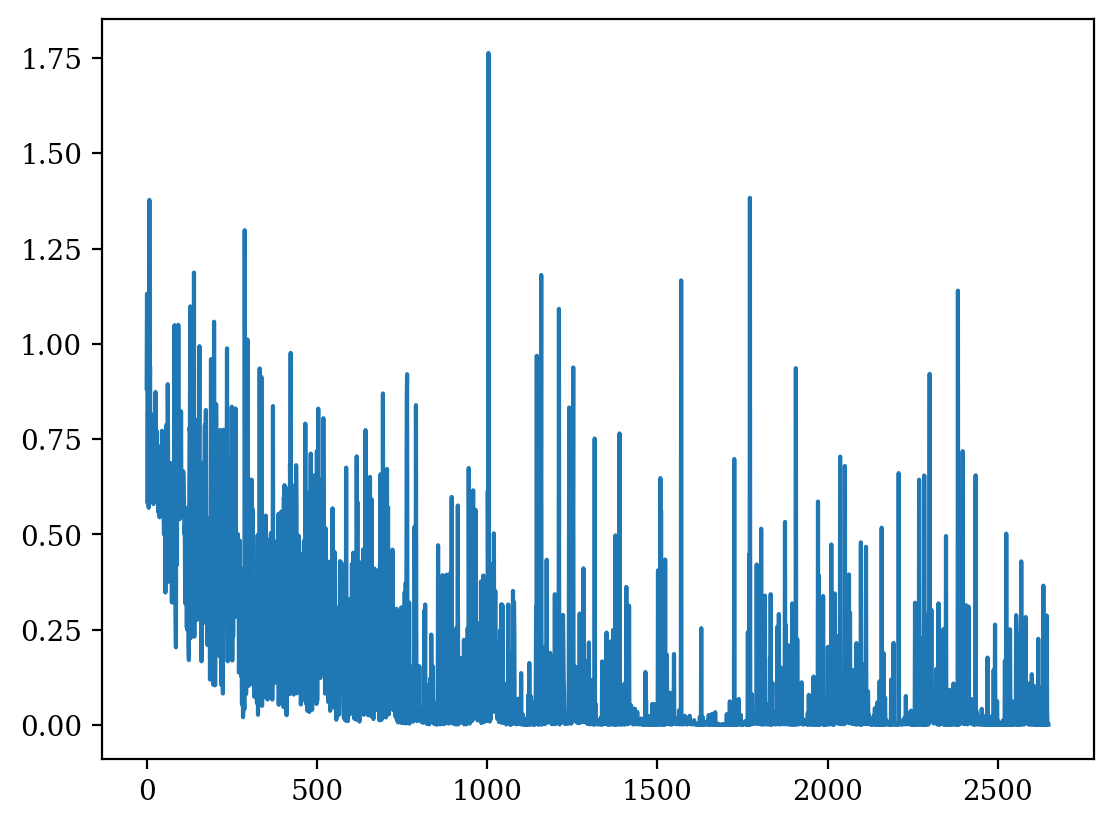

In [36]:
#----
from tqdm import tqdm
loss_list=[]
for epoch in range(10):
    tot_loss = 0
    for step, inputs in enumerate(tqdm(train_dataloader)):
        if use_cuda:
            inputs = inputs.cuda()
        logits = prompt_model(inputs)
        labels = inputs['label']
        loss = loss_func(logits, labels)
        loss.backward()
        tot_loss += loss.item()
        optimizer1.step()
        optimizer1.zero_grad()
        optimizer2.step()
        optimizer2.zero_grad()
        loss_list.append(loss.item())
    tot_loss=tot_loss/len(train_dataloader)
    print('Training Loss: {:.6f}'.format(tot_loss))
#---
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.rcParams['font.family']='serif'
plt.plot(range(len(loss_list)),loss_list)

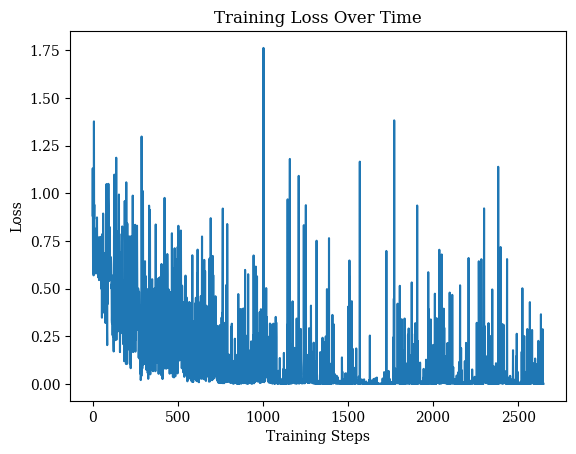

In [37]:
import matplotlib.pyplot as plt

plt.figure(dpi=100)
plt.rcParams['font.family'] = 'serif'

# Plotting the loss over training steps
plt.plot(range(len(loss_list)), loss_list)

# Naming the x-axis and y-axis
plt.xlabel('Training Steps')
plt.ylabel('Loss')

# Adding a title to the plot
plt.title('Training Loss Over Time')

plt.savefig("loss-gpt2-10epoch.png")
# Display the plot
plt.show()


In [38]:
allpreds = []
alllabels = []
for step, inputs in enumerate(tqdm(validation_dataloader)):
    if use_cuda:
        inputs = inputs.cuda()
    logits = prompt_model(inputs)
    labels = inputs['label']
    alllabels.extend(labels.cpu().tolist())
    allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())

100%|██████████| 26/26 [00:04<00:00,  5.89it/s]


In [39]:
acc = sum([int(i==j) for i,j in zip(allpreds, alllabels)])/len(allpreds)
print(acc)

0.8267326732673267


In [40]:
from google.colab import files

pred_df = pd.DataFrame(allpreds)
pred_df.to_csv('predict_gpt2-10epoch.csv', index=False)

# Download the file to your local machine
files.download('predict_gpt2-10epoch.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>